In [ ]:
from caveclient import CAVEclient
from standard_transform.datasets import v1dd_ds
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

client = CAVEclient("v1dd_public")

layer_bounds = [
    -15,
    91,
    261,
    391,
    537,
    753,
]  # These are approximate depth values in post-transformed microns for the pial surface, L1-L2/3 border, L2/3-L4 border, etc. down to the L6-wm border.

In [ ]:
# from pathlib import Path

# def load_cell_type_table():
#     return pd.read_feather(Path("./data/soma_and_cell_type_1196.feather"))

# def load_synapse_table():
#     return pd.read_feather(Path("./data/syn_df_all_to_proofread_to_all_1196.feather"))

# def load_proofread_ids():
#     return np.load(Path('./data/proofread_axon_list_1196.npy'))

In [ ]:
# This step presumes the suggested data_io module

from data_io import *

#### Step 0. Prepare some useful dataframes

1. Set up a dataframe with cell types and soma depth as well as if cells are proofread or not.
2. Set up the synapse dataframe for querying later.

In [ ]:
ct_df = load_cell_df()

In [ ]:
ct_df["soma_depth"] = v1dd_ds.transform_nm.apply_dataframe(
    "pt_position", ct_df, projection="y"
)
ct_df.soma_depth.head()  # Approximate cell depth from pial surface in microns

0    531.679864
1    572.904495
2    199.288722
3    115.141756
4    464.737835
Name: soma_depth, dtype: float64

In [ ]:
# What we are about to do requres that no root ids are duplicated in this, so let's double check:

ct_df.drop_duplicates("pt_root_id", keep=False, inplace=True)

In [ ]:
proofread_ids = load_proofread_axon_list()
ct_df["is_proofread"] = ct_df["pt_root_id"].isin(proofread_ids)

In [ ]:
syn_df = load_synapse_df()

#### Solution for Question 1. Plot the synaptic outputs of a proofread neuron across space.

We want to visualize the combination of the spatial distribution of a neuron's synaptic outputs and where on their target cells they connect.
Make a scatter plot where:

1. Every dot is a synapse from one cell of interest onto any cell-typed target cell.
2. The x-axis represents the depth of the target cell's *soma*.
2. The y-axis represents the depth of the *synapse*.
<!-- 3. Each point is colored by the cell type of the target cell . -->
<!-- 4. Points are sized by the strength of the synaptic connection (optional). -->

In [ ]:
# Let's start with a basket cell

pre_root_id = ct_df.query('cell_type == "PTC" and is_proofread').iloc[0].pt_root_id
print("Presynaptic root id:", pre_root_id)

Presynaptic root id: 864691132729533614


In [ ]:
# Step i. Merge target soma depth onto syn_df:

syn_df_ct = syn_df.query(
    "pre_pt_root_id == @pre_root_id"
).merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "cell_type": "cell_type_post",
            "cell_type_coarse": "ei_post",
            "soma_depth": "soma_depth_post",
            "pt_root_id": "post_pt_root_id",
        }
    ),
    on="post_pt_root_id",
    how="inner",  # We won't plot synapses that aren't onto single neurons, so an inner join is acceptable here.
)

In [ ]:
# Add the synapse depth as well

syn_df_ct["synapse_depth"] = v1dd_ds.transform_nm.apply_dataframe(
    "ctr_pt_position", syn_df_ct, projection="y"
)

Let's do a first plot and see what we think

<Axes: xlabel='soma_depth_post', ylabel='synapse_depth'>

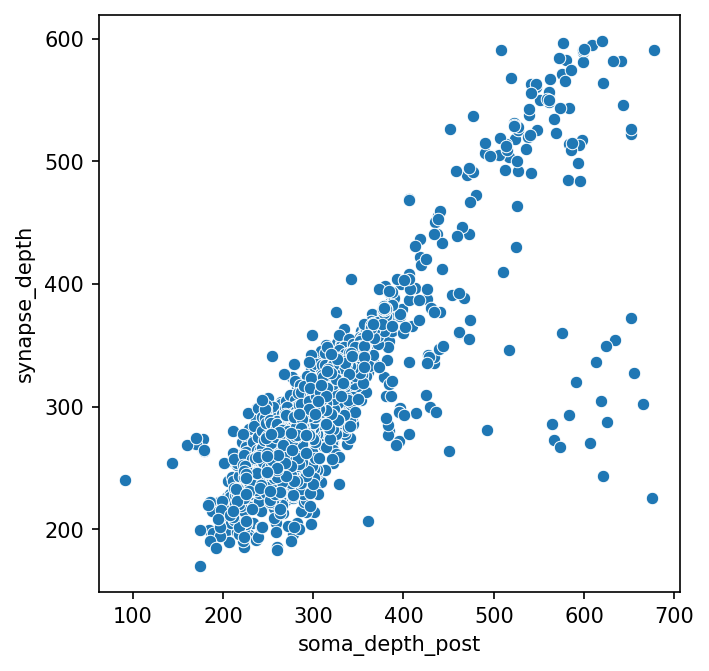

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

sns.scatterplot(x="soma_depth_post", y="synapse_depth", data=syn_df_ct, ax=ax)

It shows the data, but it's hard to interpret. Let's do a few more things.

1. We need to invert the y-axis to mirror our usual view of cortex, because lower values are actually closer to the surface since this is a depth. We can do this with `ax.invert_yaxis()`.
2. Since both the x and y axis are on the same scale, we should make sure they are the same size with `ax.set_aspect('equal')` and also set the limits to be the same with `ax.set_xlim()` and `ax.set_ylim()`.
3. Let's add a reference at the various layer borders. We can add vertical and horizontal lines with `ax.hlines` and `ax.vlines`.
4. The dots are currently overlapping quite a bit, so we might want to add some transparency with the `alpha` parameter and change the size a bit.

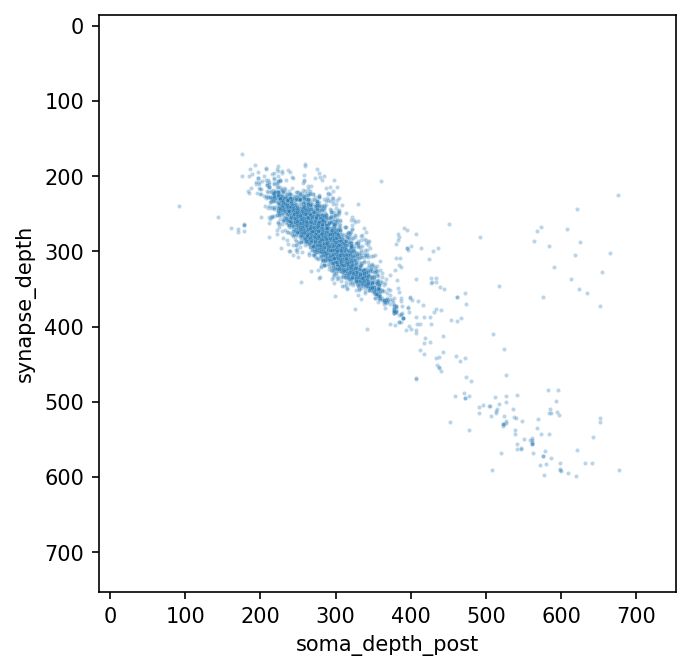

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct,
    ax=ax,
    s=4,
    alpha=0.3,
    legend=False,
)

ax.set_xlim(layer_bounds[0], layer_bounds[-1])
ax.set_ylim(layer_bounds[0], layer_bounds[-1])
ax.set_aspect("equal")
ax.invert_yaxis()

Now we can see a lot more structure. What do you notice about where synapses are relative to the depth of their target cell body?
And what do you notice about where synapses are across cortical depth?

We can do a bit better by adding more context:

1. Layer boundaries, so we can have a sense of where synapses and targets are located within the cortical layers.
2. A color palette to distinguish between excitatory and inhibitory neurons.
3. Put a dot where the presynaptic neuron's soma

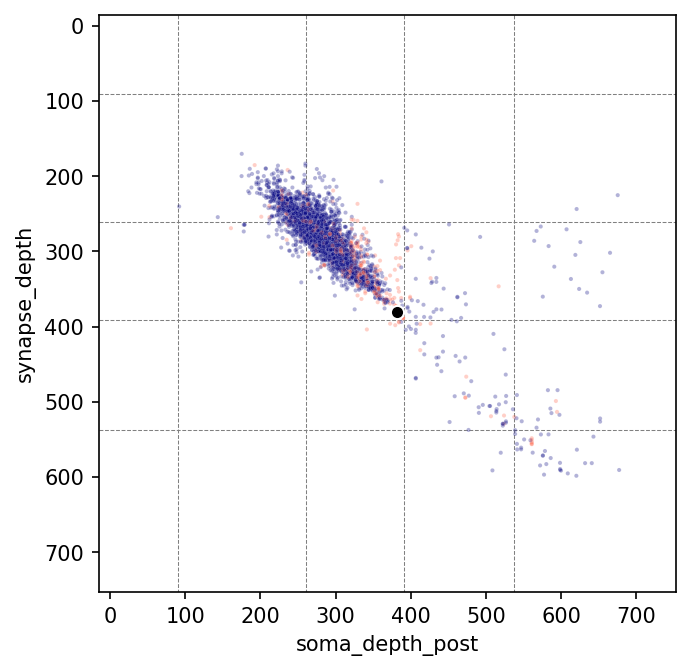

In [ ]:
ei_palette = {"E": "navy", "I": "tomato"}

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)


sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct,
    ax=ax,
    s=4,
    alpha=0.3,
    legend=False,
    hue="ei_post",
    palette=ei_palette,
)

if pre_root_id in ct_df["pt_root_id"].values:
    soma_depth = ct_df[ct_df["pt_root_id"] == pre_root_id].soma_depth.values[0]
    ax.scatter(soma_depth, soma_depth, color="k", marker="o", edgecolor="w", s=40)

ax.set_xlim(layer_bounds[0], layer_bounds[-1])
ax.set_ylim(layer_bounds[0], layer_bounds[-1])
ax.set_aspect("equal")
ax.invert_yaxis()

# add horizontal and vertical lines where layers are
ax.hlines(
    layer_bounds[1:],
    layer_bounds[0],
    layer_bounds[-1],
    color="gray",
    linestyle="--",
    linewidth=0.5,
    zorder=-10,
)  # The `zorder` parameter puts the lines behind the scatter points
ax.vlines(
    layer_bounds[1:],
    layer_bounds[0],
    layer_bounds[-1],
    color="gray",
    linestyle="--",
    linewidth=0.5,
    zorder=-10,
)

Now we can see that not only are most of the synapses at about the same depth as the target soma, most of the targets are in the bottom half of layer 2/3 and layer 4 and a few go even deeper.
We can also see that most targets are excitatory.

It is a bit hard to see the inhibitory vs excitatory targets since they overlap so much, so we can go even further and plot E and I in two plots with the same approach. Here, we will make two axes. The first axis will show the excitatory targets and the second axis will show the inhibitory targets.
In each axis, let's plot all synapses in gray, then plot the excitatory or inhibitory synapses on top with color. We can share the same axekks with the `sharey` parameter.

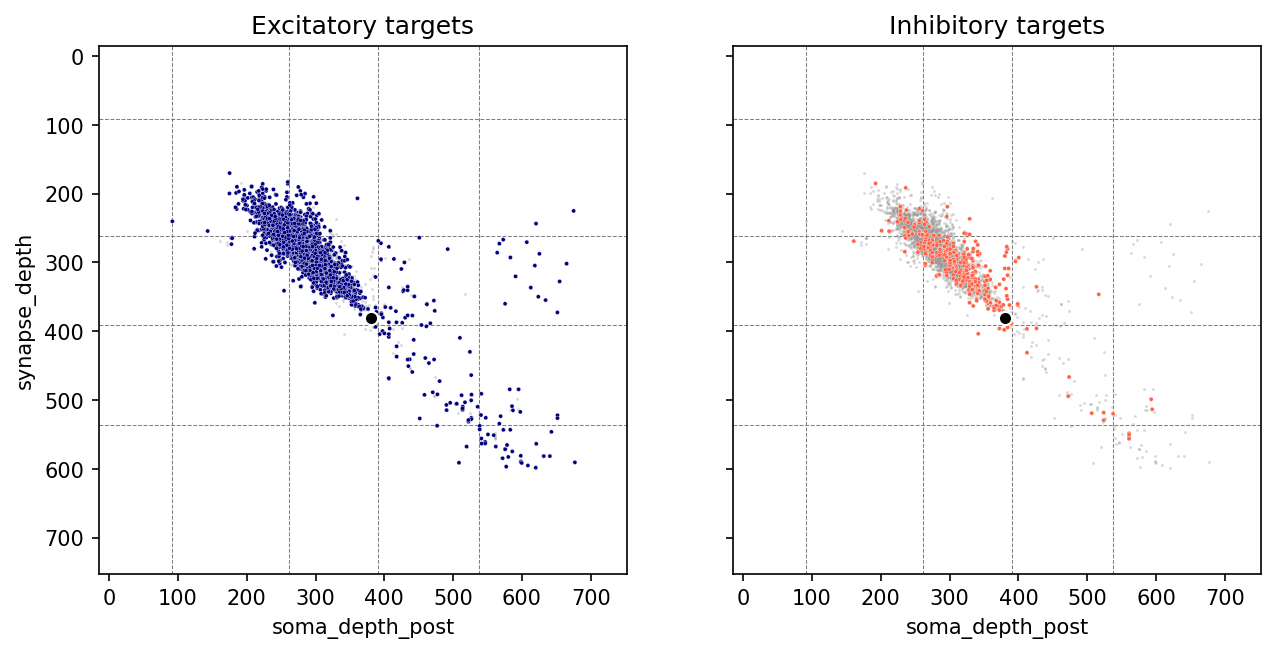

In [ ]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2, dpi=150, sharex=True, sharey=True)

ax = axes[0]
sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct,
    ax=ax,
    s=2,
    alpha=0.3,
    legend=False,
    color="gray",
)

sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct[syn_df_ct["ei_post"] == "E"],
    ax=ax,
    s=4,
    alpha=1,
    legend=False,
    hue="ei_post",
    palette=ei_palette,
)
ax.set_title("Excitatory targets")
ax.set_aspect("equal")
if pre_root_id in ct_df["pt_root_id"].values:
    soma_depth = ct_df[ct_df["pt_root_id"] == pre_root_id].soma_depth.values[0]
    ax.scatter(soma_depth, soma_depth, color="k", marker="o", edgecolor="w", s=40)


ax = axes[1]
sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct,
    ax=ax,
    s=2,
    alpha=0.3,
    legend=False,
    color="gray",
)

sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct[syn_df_ct["ei_post"] == "I"],
    ax=ax,
    s=4,
    alpha=1,
    legend=False,
    hue="ei_post",
    palette=ei_palette,
)

ax.set_title("Inhibitory targets")

ax.set_xlim(layer_bounds[0], layer_bounds[-1])
ax.set_ylim(layer_bounds[0], layer_bounds[-1])
ax.set_aspect("equal")
if pre_root_id in ct_df["pt_root_id"].values:
    soma_depth = ct_df[ct_df["pt_root_id"] == pre_root_id].soma_depth.values[0]
    ax.scatter(soma_depth, soma_depth, color="k", marker="o", edgecolor="w", s=40)

ax.invert_yaxis()  # Note that we only did this one once, otherwise you will invert it back

# add horizontal and vertical lines where layers are
for ax in axes:
    ax.hlines(
        layer_bounds[1:],
        layer_bounds[0],
        layer_bounds[-1],
        color="gray",
        linestyle="--",
        linewidth=0.5,
        zorder=-10,
    )  # The `zorder` parameter puts the lines behind the scatter points
    ax.vlines(
        layer_bounds[1:],
        layer_bounds[0],
        layer_bounds[-1],
        color="gray",
        linestyle="--",
        linewidth=0.5,
        zorder=-10,
    )

##### Compare across cell types

Now let's try the same code with a different root id from a different cell type, like a dendrite targeting cell.
What do you notice about the synapse distribution and how it differs?

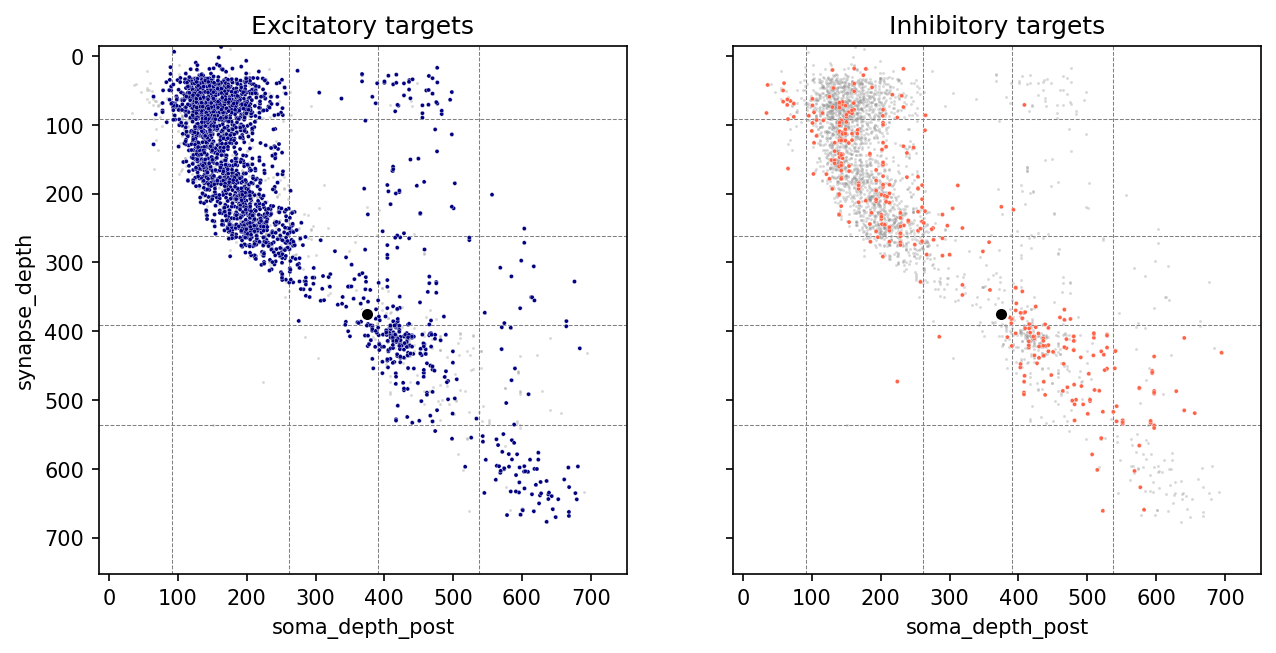

In [ ]:
pre_root_id = ct_df.query('cell_type == "DTC" and is_proofread').iloc[20].pt_root_id

syn_df_ct = syn_df.query("pre_pt_root_id == @pre_root_id").merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "cell_type": "cell_type_post",
            "cell_type_coarse": "ei_post",
            "soma_depth": "soma_depth_post",
            "pt_root_id": "post_pt_root_id",
        }
    ),
    on="post_pt_root_id",
    how="inner",
)
syn_df_ct["synapse_depth"] = v1dd_ds.transform_nm.apply_dataframe(
    "ctr_pt_position", syn_df_ct, projection="y"
)

fig, axes = plt.subplots(figsize=(10, 5), ncols=2, dpi=150, sharex=True, sharey=True)

ax = axes[0]
sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct,
    ax=ax,
    s=2,
    alpha=0.3,
    legend=False,
    color="gray",
)

sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct[syn_df_ct["ei_post"] == "E"],
    ax=ax,
    s=4,
    alpha=1,
    legend=False,
    hue="ei_post",
    palette=ei_palette,
)
ax.set_title("Excitatory targets")
ax.set_aspect("equal")
if pre_root_id in ct_df["pt_root_id"].values:
    soma_depth = ct_df[ct_df["pt_root_id"] == pre_root_id].soma_depth.values[0]
    ax.scatter(soma_depth, soma_depth, color="k", marker="o", edgecolor="w", s=40)

ax = axes[1]
sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct,
    ax=ax,
    s=2,
    alpha=0.3,
    legend=False,
    color="gray",
)

sns.scatterplot(
    x="soma_depth_post",
    y="synapse_depth",
    data=syn_df_ct[syn_df_ct["ei_post"] == "I"],
    ax=ax,
    s=4,
    alpha=1,
    legend=False,
    hue="ei_post",
    palette=ei_palette,
)

ax.set_title("Inhibitory targets")

ax.set_xlim(layer_bounds[0], layer_bounds[-1])
ax.set_ylim(layer_bounds[0], layer_bounds[-1])
ax.set_aspect("equal")
if pre_root_id in ct_df["pt_root_id"].values:
    soma_depth = ct_df[ct_df["pt_root_id"] == pre_root_id].soma_depth.values[0]
    ax.scatter(soma_depth, soma_depth, color="k", marker="o", edgecolor="w", s=40)

ax.invert_yaxis()

# add horizontal and vertical lines where layers are
for ax in axes:
    ax.hlines(
        layer_bounds[1:],
        layer_bounds[0],
        layer_bounds[-1],
        color="gray",
        linestyle="--",
        linewidth=0.5,
        zorder=-10,
    )  # The `zorder` parameter puts the lines behind the scatter points
    ax.vlines(
        layer_bounds[1:],
        layer_bounds[0],
        layer_bounds[-1],
        color="gray",
        linestyle="--",
        linewidth=0.5,
        zorder=-10,
    )

#### Solution for Question 2:

Plot connectivity between target cells based on pre- and postsynaptic soma depths.
Now let's take all of our proofread neurons and visualize their connectivity with depth.
Make a scatterplot where:

1. Each dot is a connection from one presynaptic neuron to one postsynaptic neuron.
2. The x-axis represents the depth of the presynaptic neuron's soma.
3. The y-axis represents the depth of the postsynaptic neuron's soma.
4. Each point is colored by the cell type of the postsynaptic neuron.
5. Points are sized by the strength of the synaptic connection.

The first step is to make a dataframe where each row is a connection, and all of these values are available as different columns.

In [ ]:
# Mark proofread neurons in the synapse dataframe so we can filter out everything else

syn_df["pre_proofread"] = syn_df["pre_pt_root_id"].isin(proofread_ids)
syn_df["post_proofread"] = syn_df["post_pt_root_id"].isin(proofread_ids)

In [ ]:
# Let's make a dataframe where each row is a "connection" between a presynaptic and postsynaptic neuron, with the number of synapses and their summed size as two different measures of the connection weight.
# This involves a "group-by" on both the presynaptic and postsynaptic neuron IDs and aggregating both the count of synapses and their summed synapse size.

connectivity_df = (
    syn_df.query("pre_proofread and post_proofread")
    .groupby(["pre_pt_root_id", "post_pt_root_id"])
    .agg(num_synapses=("pre_pt_root_id", "count"), sum_size=("size", "sum"))
    .reset_index()
)

connectivity_df.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size
0,864691132534275418,864691132619649223,1,2620
1,864691132534275418,864691132656860272,1,898
2,864691132534275418,864691132659029623,3,3828
3,864691132534275418,864691132663192644,1,4488
4,864691132534275418,864691132663898692,1,1556


In [ ]:
# To merge depth information, we can merge with the cell type dataframe like so. Renaming the columns ahead of time just keeps things more simple, but is not necessary.

connectivity_df.merge(
    ct_df[["pt_root_id", "soma_depth"]].rename(
        columns={"pt_root_id": "pre_pt_root_id", "soma_depth": "soma_depth_pre"}
    ),
    on="pre_pt_root_id",
)

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,soma_depth_pre
0,864691132534275418,864691132619649223,1,2620,307.933654
1,864691132534275418,864691132656860272,1,898,307.933654
2,864691132534275418,864691132659029623,3,3828,307.933654
3,864691132534275418,864691132663192644,1,4488,307.933654
4,864691132534275418,864691132663898692,1,1556,307.933654
...,...,...,...,...,...
92157,864691133313665616,864691132852413955,2,2673,608.639135
92158,864691133313665616,864691132973162293,1,2758,608.639135
92159,864691133313665616,864691132980861372,2,2643,608.639135
92160,864691133313665616,864691133121872229,1,502,608.639135


In [ ]:
# In fact, we want both pre and post synaptic depth information as well as cell type information, so let's do the more complicated version:

connectivity_depth_df = connectivity_df.merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "pt_root_id": "pre_pt_root_id",
            "soma_depth": "soma_depth_pre",
            "cell_type": "cell_type_pre",
            "cell_type_coarse": "ei_pre",
        }
    ),
    on="pre_pt_root_id",
).merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "pt_root_id": "post_pt_root_id",
            "soma_depth": "soma_depth_post",
            "cell_type": "cell_type_post",
            "cell_type_coarse": "ei_post",
        }
    ),
    on="post_pt_root_id",
)

connectivity_depth_df.head(10)

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,soma_depth_pre,ei_pre,cell_type_pre,soma_depth_post,ei_post,cell_type_post
0,864691132534275418,864691132619649223,1,2620,307.933654,E,L4-IT,439.655263,I,DTC
1,864691132534275418,864691132656860272,1,898,307.933654,E,L4-IT,350.927029,I,DTC
2,864691132534275418,864691132659029623,3,3828,307.933654,E,L4-IT,343.542750,I,DTC
3,864691132534275418,864691132663192644,1,4488,307.933654,E,L4-IT,469.967499,E,L5-ET
4,864691132534275418,864691132663898692,1,1556,307.933654,E,L4-IT,597.525035,I,PTC
5,864691132534275418,864691132666054744,1,4965,307.933654,E,L4-IT,455.900796,E,L5-ET
6,864691132534275418,864691132689698824,1,1436,307.933654,E,L4-IT,411.958389,I,DTC
7,864691132534275418,864691132700001158,1,631,307.933654,E,L4-IT,419.385789,E,L5-ET
8,864691132534275418,864691132714139653,1,270,307.933654,E,L4-IT,470.241537,I,DTC
9,864691132534275418,864691132739485851,1,3425,307.933654,E,L4-IT,428.037770,E,L5-ET


Now that we have a connection dataframe with all of our information, we can construct the scatterplot similar to the above.

Since there is a lot of data here, let's split it out by coarse cell types. Start with E/E and let's scale connection size by the number of synapses.

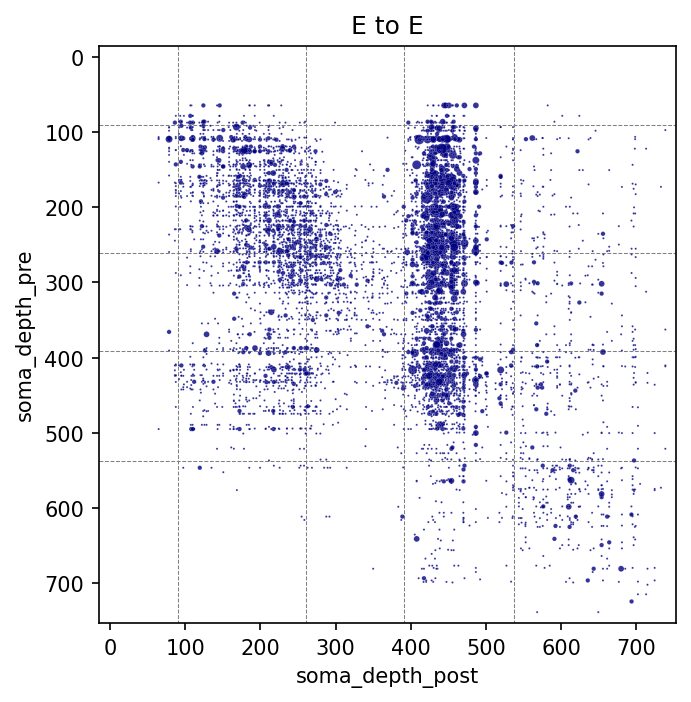

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

sns.scatterplot(
    x="soma_depth_post",
    y="soma_depth_pre",
    data=connectivity_depth_df.query('ei_pre == "E" and ei_post == "E"'),
    ax=ax,
    size="num_synapses",
    sizes=(1, 50),
    size_norm=(1, 15),  # Sets the value range mapping to the range in "sizes".
    legend=False,
    hue="ei_post",
    palette=ei_palette,
    alpha=0.8,
)

ax.set_xlim(layer_bounds[0], layer_bounds[-1])
ax.set_ylim(layer_bounds[0], layer_bounds[-1])
ax.set_aspect("equal")
ax.invert_yaxis()

ax.set_title("E to E")

# add horizontal and vertical lines where layers are
ax.hlines(
    layer_bounds[1:],
    layer_bounds[0],
    layer_bounds[-1],
    color="gray",
    linestyle="--",
    linewidth=0.5,
    zorder=-10,
)  # The `zorder` parameter puts the lines behind the scatter points
ax.vlines(
    layer_bounds[1:],
    layer_bounds[0],
    layer_bounds[-1],
    color="gray",
    linestyle="--",
    linewidth=0.5,
    zorder=-10,
)

Now let's split out E->I, E->E, I->E, and I->I into four separate plots:

In [286]:
connectivity_depth_df.query('ei_pre == "I" and ei_post == "I"')

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,soma_depth_pre,ei_pre,cell_type_pre,soma_depth_post,ei_post,cell_type_post
86,864691132536286810,864691132572190492,2,1502,471.127803,I,DTC,99.899983,I,PTC
87,864691132536286810,864691132574470970,3,2071,471.127803,I,DTC,528.755799,I,DTC
94,864691132536286810,864691132640160656,1,773,471.127803,I,DTC,65.218348,I,STC
96,864691132536286810,864691132644866746,1,1330,471.127803,I,DTC,334.302352,I,PTC
97,864691132536286810,864691132647454284,7,7830,471.127803,I,DTC,543.242831,I,DTC
...,...,...,...,...,...,...,...,...,...,...
91992,864691133311980112,864691132875841271,1,2633,131.243102,I,ITC,480.905183,I,PTC
91997,864691133311980112,864691132939082462,10,11126,131.243102,I,ITC,150.760048,I,DTC
91998,864691133311980112,864691133010159312,1,163,131.243102,I,ITC,203.403149,I,ITC
92000,864691133311980112,864691133049361508,1,595,131.243102,I,ITC,233.618786,I,PTC


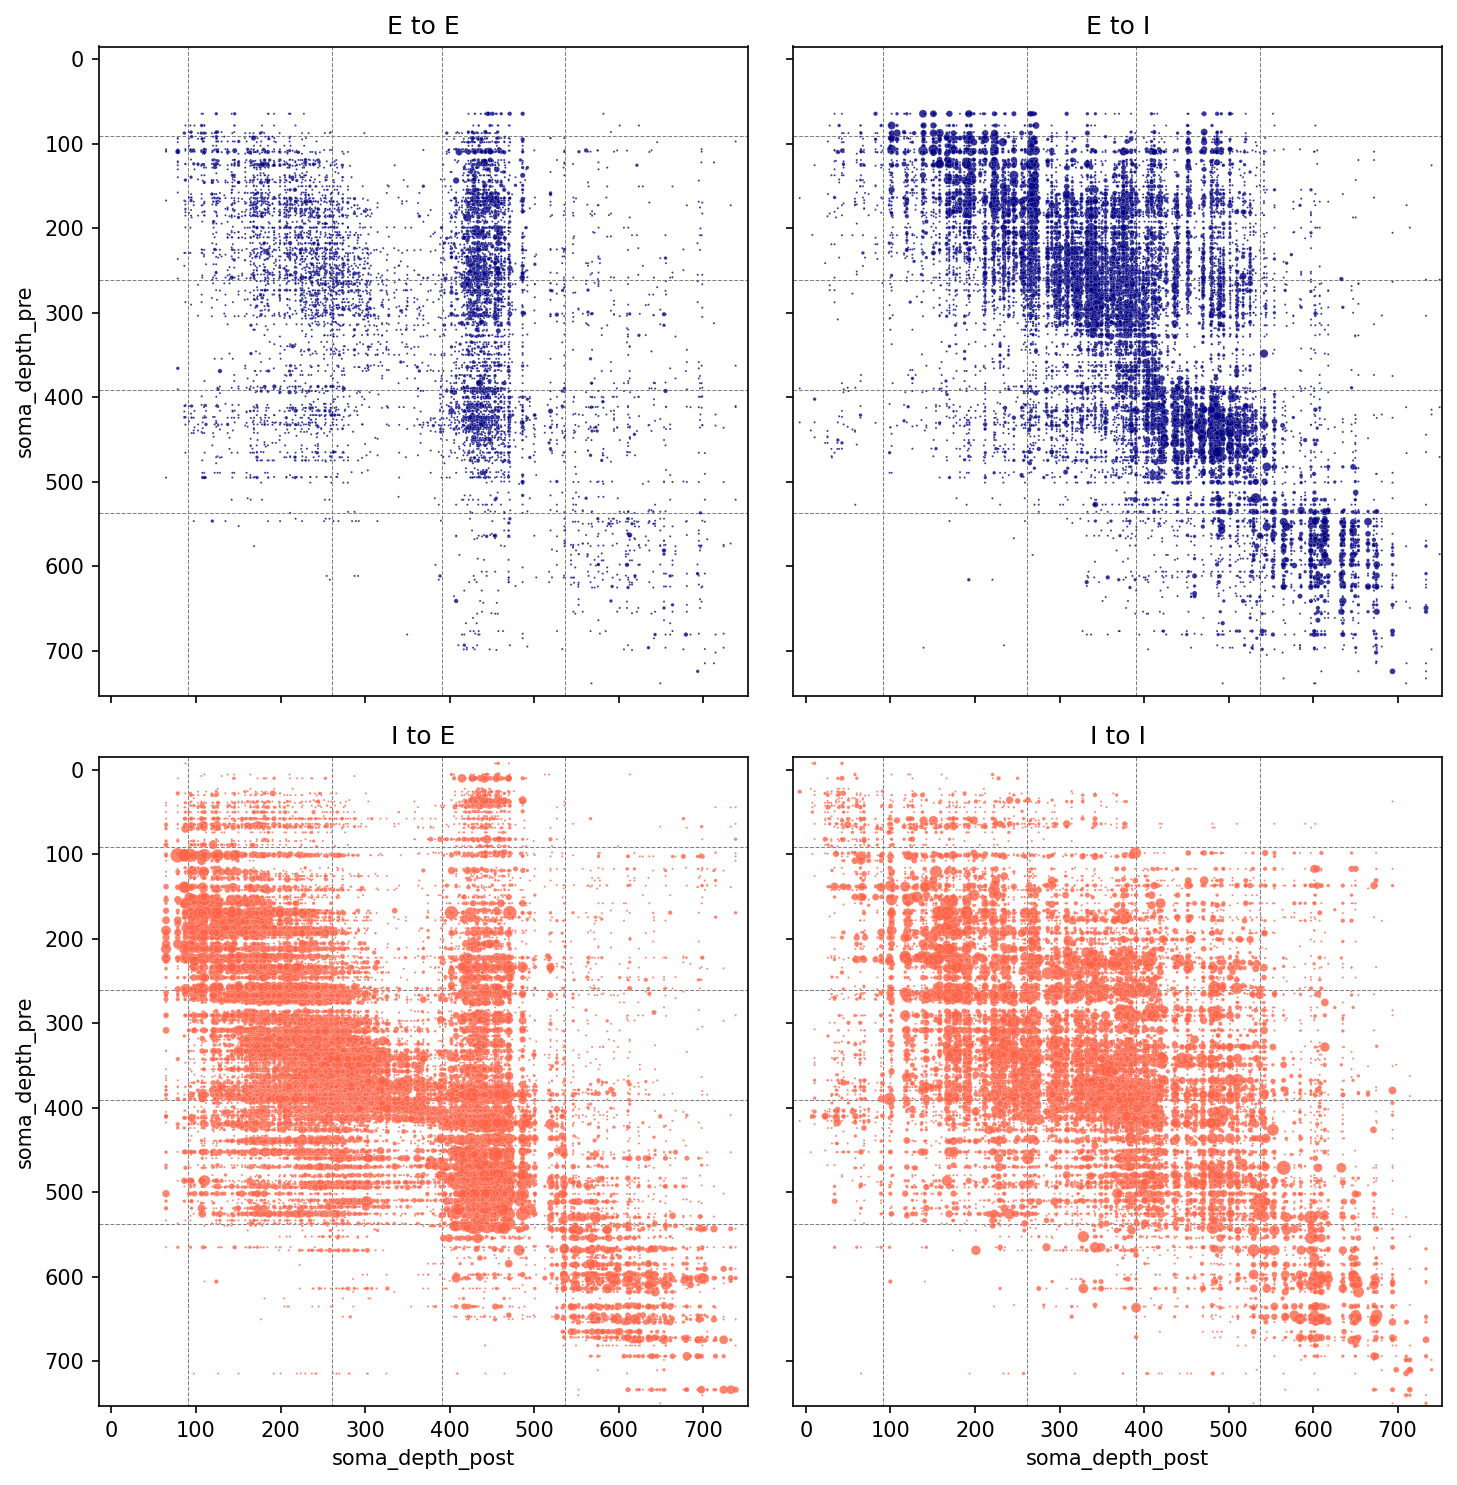

In [ ]:
fig, axes = plt.subplots(
    figsize=(10, 10),
    ncols=2,
    nrows=2,
    sharex=True,
    sharey=True,
    dpi=150,
    tight_layout=True,
)

ct_category = ["E", "I"]
for pre_ind in [0, 1]:
    for post_ind in [0, 1]:
        ax = axes[pre_ind, post_ind]
        pre_cat = ct_category[pre_ind]
        post_cat = ct_category[post_ind]
        sns.scatterplot(
            x="soma_depth_post",
            y="soma_depth_pre",
            data=connectivity_depth_df.query(
                "ei_pre == @pre_cat and ei_post == @post_cat"
            ),
            ax=ax,
            size="num_synapses",
            sizes=(1, 50),
            size_norm=(1, 30),  # Sets the value range mapping to the range in "sizes".
            legend=False,
            hue="ei_pre",
            palette=ei_palette,
            alpha=0.8,
        )

        ax.set_xlim(layer_bounds[0], layer_bounds[-1])
        ax.set_ylim(layer_bounds[0], layer_bounds[-1])
        ax.set_aspect("equal")

        ax.set_title(f"{pre_cat} to {post_cat}")

        # add horizontal and vertical lines where layers are
        ax.hlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )  # The `zorder` parameter puts the lines behind the scatter points
        ax.vlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )

ax.invert_yaxis()
